In [35]:
# Methods for weight initialization

# 1. Default (automatically from pytorch)

# 2. Uniform (sigmoid WORKS BETTER)

# 3. Xavier normal and uniform (sigmoid and tanh)

# 4. HE normal and uniform (Relu)

In [36]:
# DROPOUT = METHOD TO PREVENT OVERFITTING 

# Overfitting is a condition that occurs when a machine learning or deep neural network model performs significantly better for training data 
# than it does for new data.

In [37]:
# IT IS A REGULARIZATION TECHNIQUE APPLIED IN NEURAL NETWORKS
# IT MULTIPLIES THE ACTIVATION FUNCTION WITH THE BERNOULLI RANDOM VARIABLE r

# IT CONTAINS 2 PHASES:

# PHASE 1: 
# TRAIN : WHERE WE IMPLEMENT THE DROPOUT METHOD (TO THE FORWARD STEP)


# PHASE 2: 
# EVALUATON : WE TURN OFF THE DROPOUT TO TEST THE MODEL'S PERFOMANCE (WE RUN THE NETWORK WITH ALL THE NEURONS BEING ACTIVE)

# P = HYPERPARAMETER 
# !!! THE MORE NEURONS THE LARGER THE P IS  (usually p = 0.5)
# !!! FOR THE LAYERS WITH SMALL NUMBER OF NEURONS --> 0.05 < p < 0.1

In [38]:
# Bring in important Librairies

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [39]:
# Create some data

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=10000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
            
        self.len = self.x.shape[0]            
        
    # Getter        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

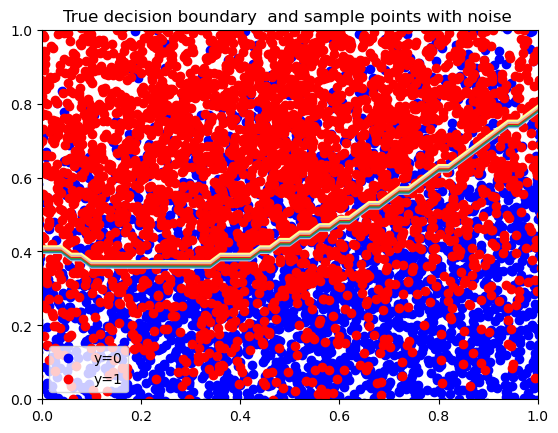

In [40]:
# Create a dataset object

data_set = Data(noise_std=0.2) # ADD SOME NOISE

# Get some validation data

torch.manual_seed(0) 
validation_set = Data(train=False)

# plot the training dataset

data_set.plot()   

In [41]:
# Define the class for neural network model with He Initialization

class Net_He(nn.Module):
    
    # Constructor
    def __init__(self, Layers, p=0):
        super(Net_He, self).__init__()
        
        self.drop = nn.Dropout(p=p, inplace=True) # WE ARE ADDING DROPOUT METHOD
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity='relu')
            self.hidden.append(linear)

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = F.relu(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [42]:
# Create the model 

Layers = [2, 300, 300, 2]

model_drop = Net_He(Layers, p=0.5)   

In [43]:
# Loss Criterion, DataLoader, Optimizer

criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset=data_set, batch_size=2000)
validation_loader = DataLoader(dataset=validation_set, batch_size=5000)

optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)

In [44]:
# time to train the model

# Define function to  train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs):
    i = 0
    loss_accuracy = {'training_loss': [], 'validation_accuracy': []}  
    
    #n_epochs
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            
            model_drop.train()
            
            optimizer.zero_grad()
            
            z = model(x)
            
            loss = criterion(z, y)
            loss.backward()
            
            optimizer.step()
            
            loss_accuracy['training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in validation_loader:
            
            model_drop.eval()
            
            yhat = model(x)
            
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len(validation_set))
        loss_accuracy['validation_accuracy'].append(accuracy)
    
    return loss_accuracy

In [45]:
# train the model for 30 epochs

training_results_He = train(model_drop, criterion, train_loader, validation_loader, optimizer_drop, epochs=30)

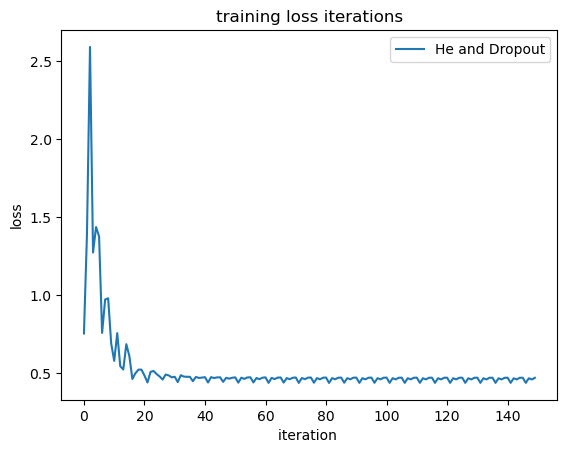

In [47]:
# Plot the loss

plt.plot(training_results_He['training_loss'], label='He and Dropout')
plt.ylabel('loss')
plt.xlabel('iteration ') 
plt.title('training loss iterations')
plt.legend()

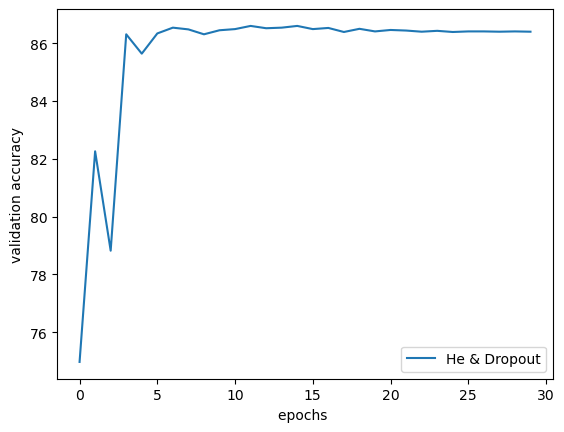

In [48]:
# Plot the accuracy

plt.plot(training_results_He['validation_accuracy'], label='He & Dropout')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()